### The goal of this program is to perform a baseline analysis for a standard unified loan prediction dataset using a simple ANN

In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time #check min_threshold values for cloud storage
from sklearn.model_selection import train_test_split #don't use for time-series baseline!
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
df = pd.read_csv("../../data/loans/train.csv")

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Data pre-processing

In [4]:
def preprocess_df(dataframe, isTest=False):
    """Preprocess a dataframe, unique to the loan_prediction dataset"""
    #perform deep copy, fixes self assignment bug:
    #https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
    df = dataframe.copy(deep=True)
    
    null_df = np.sum(df.isnull())
    print(null_df) 
    print(f"\nTotal null values: {np.sum(null_df)}") #get total number of null values
    ### remove all rows with null values
    df = df.dropna(how='any',axis=0) 
    del df['Loan_ID'] #remove Loan_ID (irrelevant)

    # convert to binary variables

    ##----------------------------------------------------------------------------
    #### ----------------------------------Table----------------------------------
    ##----------------------------------------------------------------------------

    #> ----Gender---
    ## - Male: 0
    ## - Female: 1
    df.loc[(df.Gender == 'Male'),'Gender']=0
    df.loc[(df.Gender == 'Female'),'Gender']=1

    #> ----Married---
    ## - No: 0
    ## - Yes: 1
    df.loc[(df.Married == 'Yes'),'Married']=0
    df.loc[(df.Married == 'No'),'Married']=1

    #> ----Education---
    ## - Not Graduate: 0
    ## - Graduate: 1
    df.loc[(df.Education == 'Not Graduate'),'Education']=0
    df.loc[(df.Education == 'Graduate'),'Education']=1

    #> ----Self_Employed---
    ## - No: 0
    ## - Yes: 1
    df.loc[(df.Self_Employed == 'No'),'Self_Employed']=0
    df.loc[(df.Self_Employed == 'Yes'),'Self_Employed']=1


    #> ----Property_area---
    ## - Rural: 0
    ## - Urban: 1
    ## - Semiurban: 2
    df.loc[(df.Property_Area == 'Rural'),'Property_Area']=0
    df.loc[(df.Property_Area == 'Urban'),'Property_Area']=1
    df.loc[(df.Property_Area == 'Semiurban'),'Property_Area']=2
    
    
    #> ----Loan_Status--- (ONLY for Training set)
    ## - No: 0
    ## - Yes: 1
    if(not isTest):
        df.loc[(df.Loan_Status == 'N'),'Loan_Status']=0
        df.loc[(df.Loan_Status == 'Y'),'Loan_Status']=1

    #> -----Dependents-----
    #set max as 
    df.loc[(df.Dependents == '3+'), 'Dependents'] = 3
    ##----------------------------------------------------------------------------
    #### ----------------------------------Table----------------------------------
    ##----------------------------------------------------------------------------

    #!!! Typecase to float (for tensors below)
    df = df.astype(float)
    
    return df

In [5]:
df = preprocess_df(df)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Total null values: 149


In [6]:
df.head() #processed

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,0.0,0.0,1.0,1.0,0.0,4583.0,1508.0,128.0,360.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,3000.0,0.0,66.0,360.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,2583.0,2358.0,120.0,360.0,1.0,1.0,1.0
4,0.0,1.0,0.0,1.0,0.0,6000.0,0.0,141.0,360.0,1.0,1.0,1.0
5,0.0,0.0,2.0,1.0,1.0,5417.0,4196.0,267.0,360.0,1.0,1.0,1.0


In [7]:
#split into training and testing
X = df.drop('Loan_Status',axis=1).values
y = df['Loan_Status'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
print(f"Training data feature space: {X_train.shape}")
print(f"Testing data feature space: {X_test.shape}")

Training data feature space: (336, 11)
Testing data feature space: (144, 11)


In [9]:
### Create tensors from np.ndarry main data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Enable cuda if available

X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [10]:
## split X_train and y_train into N nodes representing N federated clients
N = 2
X_federated_train = torch.chunk(X_train, N, dim=0)
y_federated_train = torch.chunk(y_train, N, dim=0)

assert(len(X_federated_train) == N == len(y_federated_train))

## Building Federated Model

In [11]:
#main model for loan prediction (try out different values for hidden layers to improve baseline)
class NN(nn.Module):
    def __init__(self, input_features=11, layer1=20, layer2=20, out_features=2):
        """Initialize the model for loan prediction"""
        super().__init__()
        self.fc1 = nn.Linear(input_features, layer1)
        self.fc2 = nn.Linear(layer1, layer2)
        self.out = nn.Linear(layer2, out_features)
        
    def forward(self, x):
        """Forward pass with 11 input features"""
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [12]:
# seed the model for reproducibility (ideally across all nodes, later...)
torch.manual_seed(0)

#define client and server models, where there are N clients and 1 master/server model
clients = [NN().to(device) for _ in range(N)]
server = NN().to(device)

In [13]:
server ##describe model, sort of (integrate tensorboard into PyTorch, not now tho)

NN(
  (fc1): Linear(in_features=11, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (out): Linear(in_features=20, out_features=2, bias=True)
)

In [14]:
# implement backprop
losses = [nn.CrossEntropyLoss() for _ in range(N)]
optimizers = [torch.optim.Adam(clients[i].parameters(), lr=0.005) for i in range(N)]

In [15]:
def train(model, index, epochs=int(1e3), epsilon=0.5):
    """
    Train the model.
    - assumes access to following global variables: X_train, y_train, y_pred, model, loss function, & optimizer.
    @Param:
    1. epochs - number of training iterations.
    2. print_every - for visual purposes (set to None to ignore), outputs loss
    3. epsilon - threshold to break training.
    """
    start_time = time.time() #set start time
    loss_arr = [] #plot
    for i in range(1, epochs+1):
        y_pred = model(X_federated_train[index])
        loss = losses[index](y_pred, y_federated_train[index])
        loss_arr.append(loss)
        if(loss.item() <= epsilon):
            break #converged
        
        optimizers[index].zero_grad()
        loss.backward()
        optimizers[index].step()
        
    return loss_arr

## Federated Learning Setup

In [16]:
def average():
    """Perform federated averaging"""
    with torch.no_grad():
        #set server to 0.
        for name, param in server.named_parameters():
                param.copy_(torch.zeros(param.size()))
        #averaged weights
        for client in clients:
            for name, param in client.named_parameters():
                server.state_dict()[name] += (param / N)

In [17]:
def federated(t=10):
    """Run t epochs of FL setup"""
    for _ in tqdm(range(t)):
        costs = [train(client, i, epsilon=0.2) for i, client in enumerate(clients)]
        average()
    return costs #return the latest costs

In [18]:
costs = federated(t=25)

100%|██████████| 25/25 [00:18<00:00,  1.35it/s]


In [19]:
#### predict X_test data
predictions=[]
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_pred = server(data)
        predictions.append(y_pred.argmax().item())
        
predictions = np.array(predictions, dtype=np.int8)

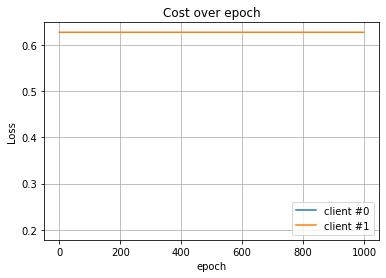

In [20]:
#graph cost
for i, cost in enumerate(costs):
    plt.plot(cost, label='client #' + str(i))
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.title("Cost over epoch")
plt.legend()
plt.grid()
plt.show()

In [21]:
loan = np.where(predictions == 1)[0]
not_loan = np.where(predictions == 0)[0]
print(f"Prediction loans count: {len(loan)}")
print(f"Prediction not loans count: {len(not_loan)}")

Prediction loans count: 141
Prediction not loans count: 3


In [22]:
score = accuracy_score(y_test, predictions)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [23]:
print("Accuracy", score)
print("***Confusion Matrix stats***")
print(f"True Negative: {tn}\nFalse Positive: {fp}\nFalse Negative: {fn}\nTrue Positive: {tp}")

Accuracy 0.7013888888888888
***Confusion Matrix stats***
True Negative: 2
False Positive: 42
False Negative: 1
True Positive: 99


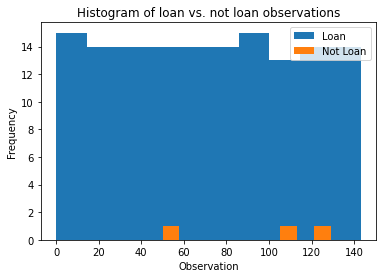

In [24]:
plt.hist(loan, label='Loan')
plt.hist(not_loan, label='Not Loan')
plt.legend()
plt.xlabel("Observation")
plt.ylabel("Frequency")
plt.title("Histogram of loan vs. not loan observations")
plt.show()

## Upload models

In [25]:
#Read more: https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(server.state_dict(), f"../model/stochastic_server_model.pth")
for i, client in enumerate(clients):
    torch.save(client.state_dict(), f"../model/stochastic_client_model_{i}.pth")